# Predicting Credit Card Defaults

The goal of this project is to predict whether customers will default on their next month bill.

The steps involved in this project are:
1. We first get the data from [BigQuery](#bigquery)
2. We need to [analyze the data](#data-analysis), in terms of whether the data is disporportionate in terms of the target values, as well as studying the distribution of a number of columns.
3. We then go ahead and build and deploy [the model](#build-model). We will do it in two steps; first we need to [preprocess](#preprocess) the data, create a pipeline, [train](#train) the model, tune [hyperparameters](#hyperparameters), and then [deploy](#deploy) the model on ML engine and make [predictions](#predict).




First off, let's set the environmental variables required to run jobs on GCP, and import all required libraries.

In [1]:
BUCKET = 'credit_card_default'  
PROJECT = 'credit default'    
REGION = 'us-central1'  

In [2]:
import os
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime, os
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.cm as cm
plt.style.use('fivethirtyeight')

from google.cloud import bigquery

### Not show warnings about the Python libraries
import warnings
warnings.filterwarnings('ignore')

Next, we'll create a new bucket on Cloud Storage.

In [4]:
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/; then
    gsutil mb -l ${REGION} gs://${BUCKET}
fi

<a id='bigquery'></a>

## Getting data from BigQuery

Let's query the required data from Big Query to familiarize ourself with the data.

In [5]:
query = """
SELECT 
    ABS(FARM_FINGERPRINT(CAST(ID AS STRING))) AS hashid,
    LIMIT_BAL,
    SEX,
    EDUCATION,
    MARRIAGE,
    AGE,
    PAY_0 AS PAY_1,
    PAY_2,
    PAY_3,
    PAY_4,
    PAY_5,
    PAY_6,
    CAST(BILL_AMT1 AS FLOAT64) AS BILL_AMT1,
    CAST(BILL_AMT2 AS FLOAT64) AS BILL_AMT2,
    CAST(BILL_AMT3 AS FLOAT64) AS BILL_AMT3,
    CAST(BILL_AMT4 AS FLOAT64) AS BILL_AMT4,
    CAST(BILL_AMT5 AS FLOAT64) AS BILL_AMT5,
    CAST(BILL_AMT6 AS FLOAT64) AS BILL_AMT6,
    CAST(PAY_AMT1 AS FLOAT64) AS PAY_AMT1,
    CAST(PAY_AMT2 AS FLOAT64) AS PAY_AMT2,
    CAST(PAY_AMT3 AS FLOAT64) AS PAY_AMT3,
    CAST(PAY_AMT4 AS FLOAT64) AS PAY_AMT4,
    CAST(PAY_AMT5 AS FLOAT64) AS PAY_AMT5,
    CAST(PAY_AMT6 AS FLOAT64) AS PAY_AMT6,
    CAST(default_payment_next_month AS INT64) AS default_payment
FROM
  `credit-default-277316.credit_default.credit_default`
"""

In [6]:
df = bigquery.Client().query(query).to_dataframe()
df.head()

,hashid,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment
0,6455268178307048695,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
1,3919889686402291073,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
2,449943323627881487,50000.0,1,1,2,37,0,0,0,0,...,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0
3,8633013323626695528,500000.0,1,1,2,29,0,0,0,0,...,542653.0,483003.0,473944.0,55000.0,40000.0,38000.0,20239.0,13750.0,13770.0,0
4,6529025537284954989,100000.0,2,2,2,23,0,-1,-1,0,...,221.0,-159.0,567.0,380.0,601.0,0.0,581.0,1687.0,1542.0,0


Now is the time for some data wrangling! We'll proceed with defining a function that will do a couple of things:
1. Checks for number of rows and columns
2. Checks for null values, and if any, replaces them with the median value in that column
3. Checks for duplicate rows and removes them, if any.

In [7]:
def check_dataset(dataframe):
    ### Check number of rows and columns:
    print("There are {} total number of clients, with {} number of columns".format(df.shape[0],df.shape[1]))
    
    ### Check for Null Values ###
    null_count = df.isnull().sum()
    
    # Replace null values with the median value in the column if any
    if np.sum(null_count)>0:
        
        # Find the columns with null values and replace their null values with the median in that column
        null_columns = df.columns[df.isna().any()].tolist()
        print('The following columns have null values:{}'.format(null_columns))
        
        for c in null_columns:
            median = df[c].median()
            df[c].fillna(median, inplace=True)
    else:
        print("There are no null values in this dataset!")
    
    
    ### Check for duplicate Values ###
    if df.duplicated().any()>0:
        print("The dataset has duplicate values which will be removed.")
        df.drop_duplicates(inplace=True)
    else:
        print("There are no duplicate values in this dataset!")
    

In [8]:
check_dataset(df)

There are 29993 total number of clients, with 25 number of columns
There are no null values in this dataset!
There are no duplicate values in this dataset!


There are no missing value, nor any duplicates in the dataframe! Great!

Also, let's get a quick sense of the data. The table below shows that the average credit limist are around 167500, and the average age of the customers is 35 years.

In [9]:
df.describe()

,hashid,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment
count,2.999300e+04,29993.000000,29993.000000,29993.000000,29993.000000,29993.000000,29993.000000,29993.000000,29993.000000,29993.000000,...,29993.000000,29993.000000,29993.000000,29993.000000,2.999300e+04,29993.000000,29993.000000,29993.000000,29993.000000,29993.000000
mean,4.629626e+18,167464.064282,1.603708,1.853132,1.551895,35.485980,-0.016837,-0.133865,-0.166172,-0.220651,...,43243.090621,40294.395659,38871.950488,5663.615344,5.918415e+03,5226.010903,4823.268463,4799.211683,5201.872737,0.221218
std,2.663416e+18,129739.247349,0.489135,0.790381,0.521972,9.217795,1.123812,1.197261,1.196958,1.169226,...,64313.133711,60759.011187,59540.773515,16565.136085,2.303949e+04,17608.969468,15658.285683,15279.623133,17689.070092,0.415074
min,3.460474e+14,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.315310e+18,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.000000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.000000,296.000000,254.000000,117.000000,0.000000
50%,4.636418e+18,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19048.000000,18104.000000,17068.000000,2100.000000,2.009000e+03,1800.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,6.932103e+18,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54468.000000,50176.000000,49171.000000,5006.000000,5.000000e+03,4505.000000,4013.000000,4031.000000,4000.000000,0.000000
max,9.223304e+18,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000


<a id='data-analysis'></a>

## EDA

### Defaults

It's important that we understand the distribution of the data from various columns. I'll define two functions to get the distinct values of each column, as well as their avarge default counts.

In [10]:
def get_distinct_values(column_name):
    sql = """
          SELECT
             {0},
             COUNT(1) AS num_rows,
             AVG(CAST(default_payment_next_month AS INT64)) AS avg_default
          FROM
             `credit-default-277316.credit_default.credit_default`
          GROUP BY
             {0}
          ORDER BY {0}
          """.format(column_name)
    return bigquery.Client().query(sql).to_dataframe()

def get_average_values(column_name):
    sql = """
          SELECT
             default_payment_next_month AS default_payment,
             AVG({0}) AS avg_values
          FROM
             `credit-default-277316.credit_default.credit_default`
          GROUP BY
             default_payment
          """.format(column_name)
    return bigquery.Client().query(sql).to_dataframe()

Let's visualize the distribution of the data for some of the features, as well as the distribution of defaults based on those features. 

Here, our target value is `*default_payment_next_month*`, with **1=yes** and **0=no**. 

The following is the description of the columns in the dataset:

- SEX: 1=Male, 2=Female 
- Education: 1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown.
- Marital Status: 1=married, 2=single, 3=others, 4=Unknown

In [11]:
default_counts = get_distinct_values('default_payment_next_month')
gender_counts = get_distinct_values('SEX')
ed_counts = get_distinct_values('EDUCATION')
marital_counts = get_distinct_values('MARRIAGE')

In [12]:
# Remove rows with education=0:
ed_counts.drop(ed_counts.loc[ed_counts['EDUCATION']==0].index, inplace=True)

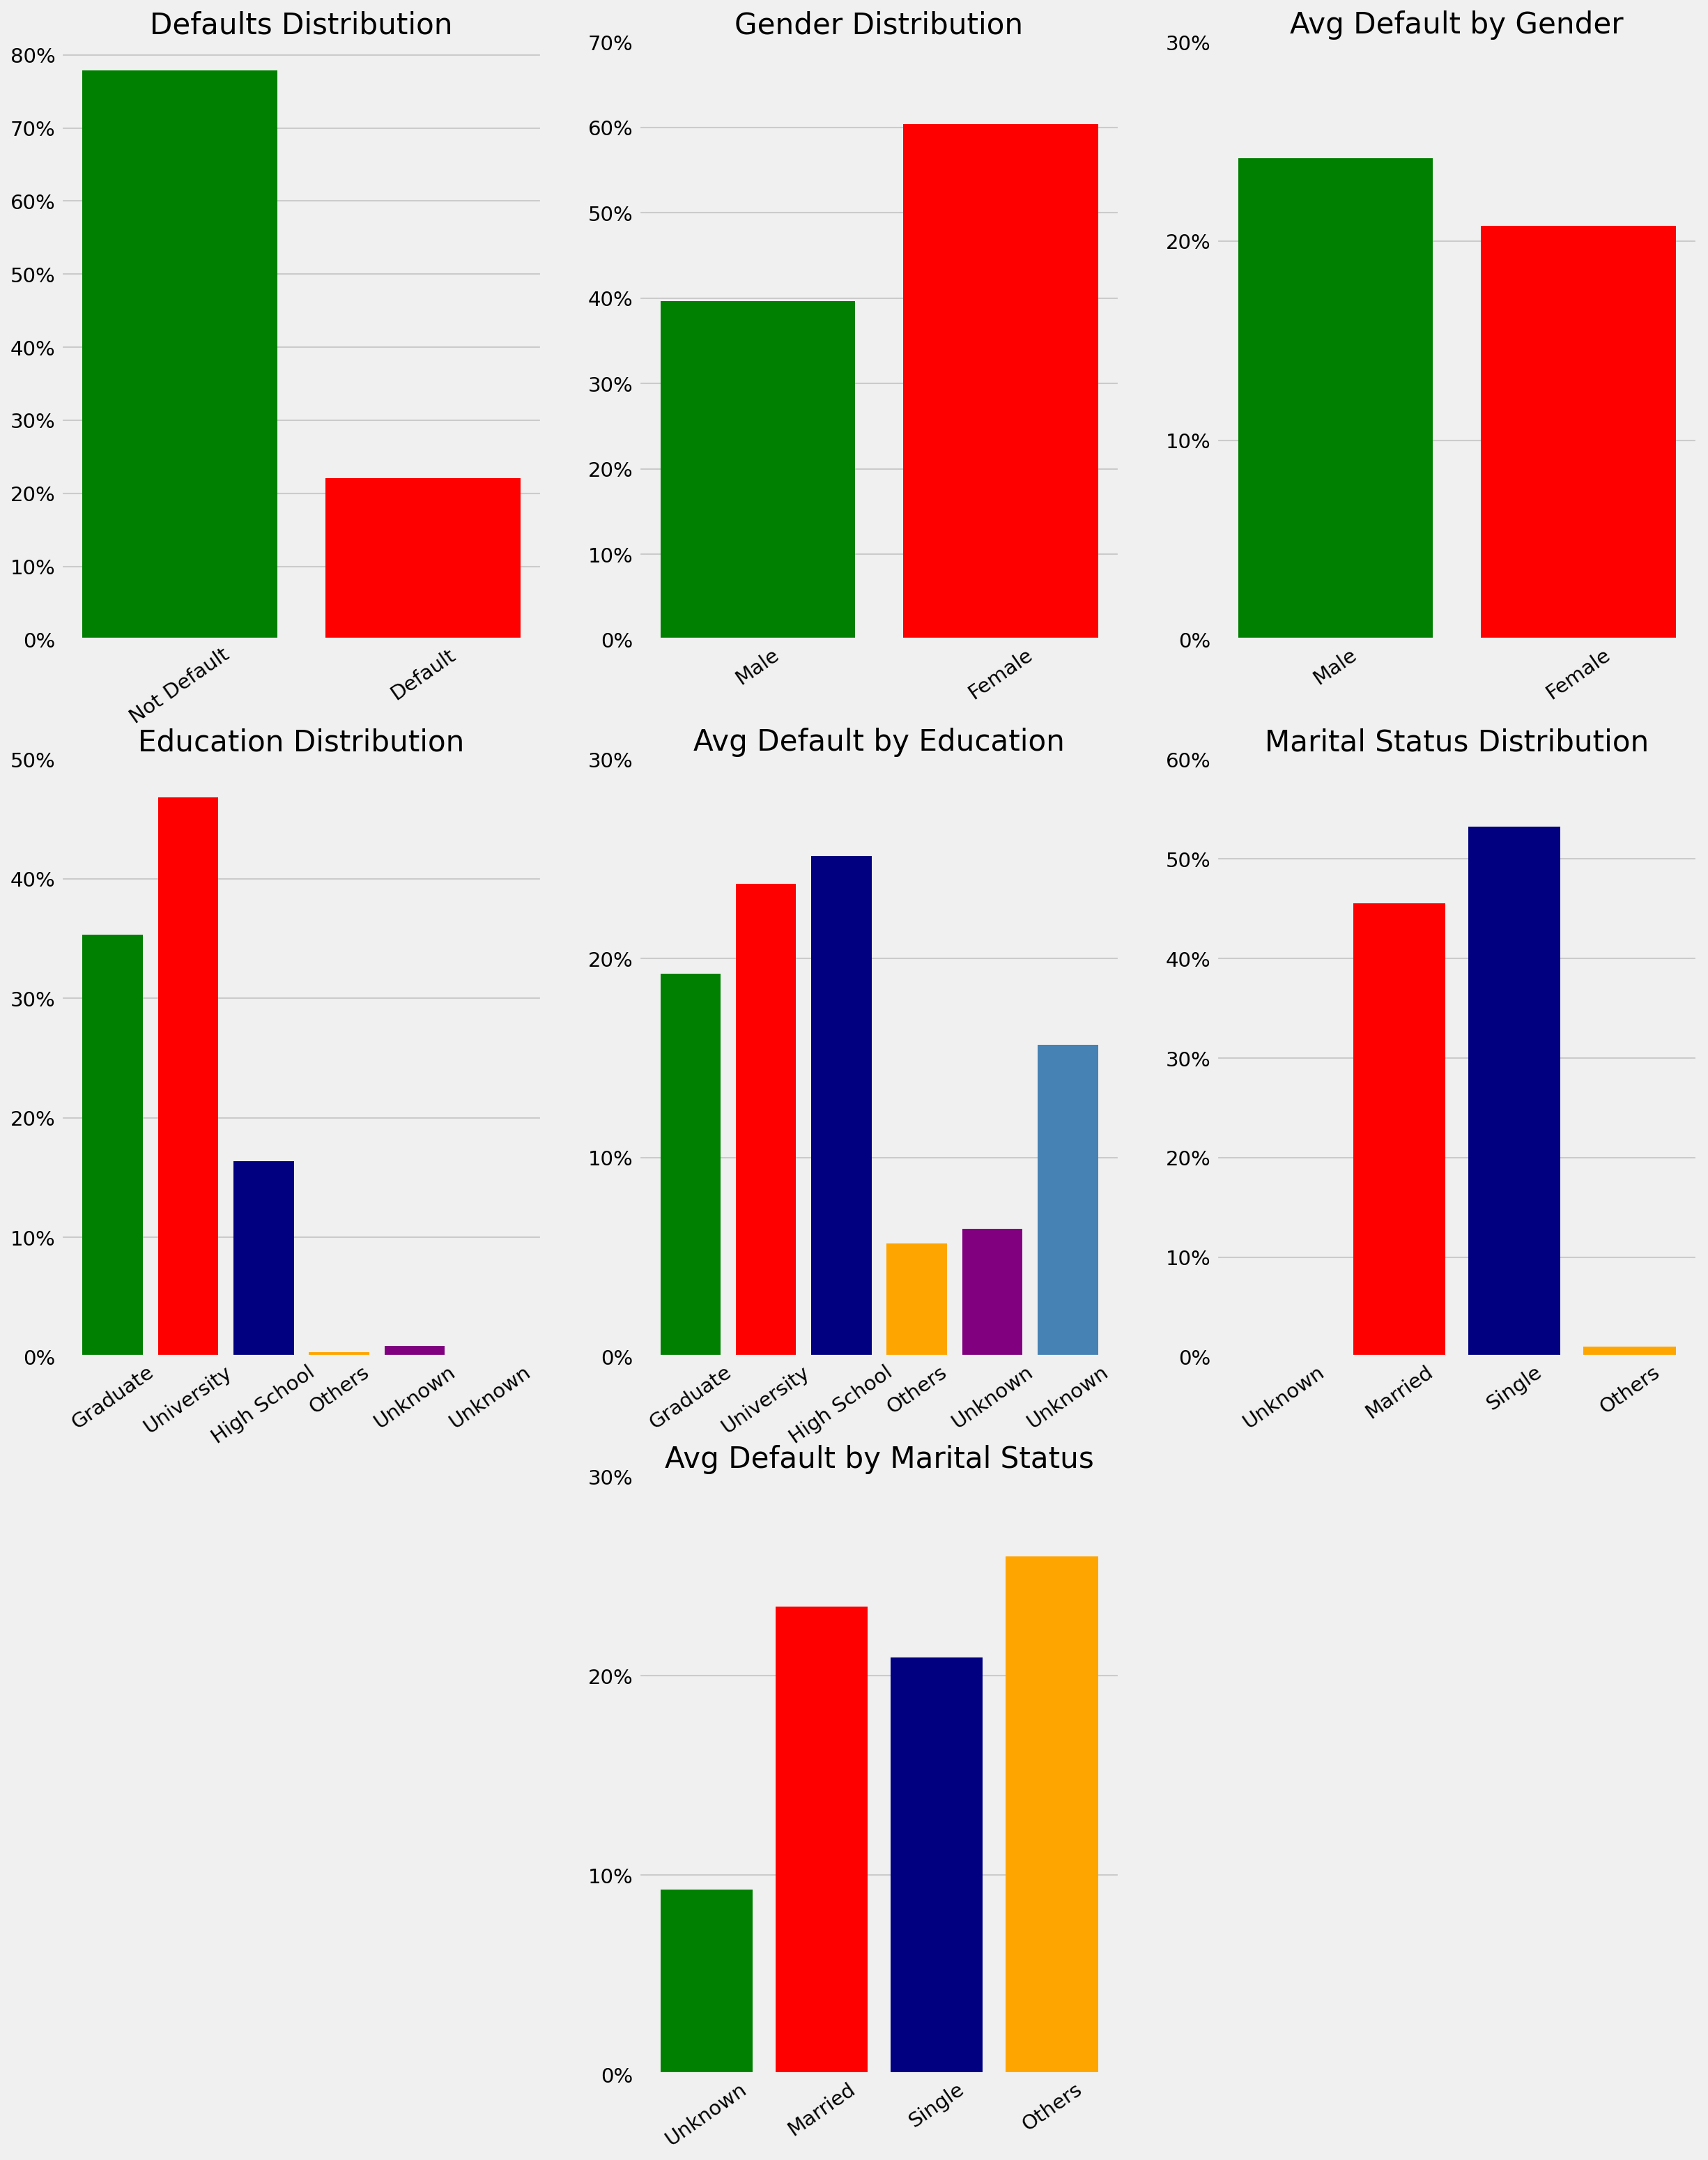

In [13]:
fig, ax= plt.subplots(figsize=(18, 24), dpi=150, nrows = 3, ncols=3)

data = [(default_counts,'Defaults',['Not Default','Default']), 
        (gender_counts,'Gender',['Male','Female']), 
        (ed_counts,'Education',['Graduate','University','High School','Others','Unknown','Unknown']), 
       (marital_counts,'Marital Status',['Unknown','Married','Single','Others'])]

color_array=['green','red','navy','orange','purple','steelblue']

p = 0
for i in range(4):
    
    ### Distribution plots
    dist = data[i][0]['num_rows']/data[i][0]['num_rows'].sum(axis=0)*100
    ax[p//3][p%3].bar(data[i][0][data[i][0].columns[0]],
                     dist,color=color_array[:len(data[i][0])])
    ax[p//3][p%3].set_title(data[i][1]+' Distribution')
    ax[p//3][p%3].set_xticks(data[i][0].loc[:,data[i][0].columns[0]].tolist())
    ax[p//3][p%3].set_xticklabels(data[i][2], ha='center', rotation=35)
    ax[p//3][p%3].set_yticks(np.arange(0,int((max(dist)//10+1)*10)+1,10))
    ax[p//3][p%3].set_yticklabels(['{}%'.format(j) for j in np.arange(0,int((max(dist)//10+1)*10)+1,10)])
    ax[p//3][p%3].grid(axis='x')
    
    ### Avg defaults per feature
    if i>0:
        p +=1
        if p==6:
            p += 1
        avg_dist = data[i][0]['avg_default']*100
        ax[p//3][p%3].bar(data[i][0][data[i][0].columns[0]],avg_dist,
           color=color_array[:len(data[i][0])])
        ax[p//3][p%3].set_title('Avg Default by '+ data[i][1])
        ax[p//3][p%3].set_xticks(data[i][0].loc[:,data[i][0].columns[0]].tolist())
        ax[p//3][p%3].set_xticklabels(data[i][2], ha='center', rotation=35)
        ax[p//3][p%3].set_yticks(np.arange(0,int((max(avg_dist)//10+1)*10)+1,10))
        ax[p//3][p%3].set_yticklabels(['{}%'.format(j) for j in np.arange(0,int((max(avg_dist)//10+1)*10)+1,10)])
        ax[p//3][p%3].grid(axis='x')
        
    p += 1 
fig.delaxes(ax[2][0])
fig.delaxes(ax[2][2])

The majority of instances are those that did not default on their credit cards. To be more precise, about 22% of instances belong to the "default" class. Given that this distribution is not terribly imbalanced, there's no need for upsampling techniques for the minority class, such as _SMOTE (Synthetic Minority Oversampling Technique)_.

We can see that the population of female customers is about 1.5 times larger than that of the male customers. But it appears that men tend to default more on their next month payment.

The majority of the customers are still pursuing their Bachelor's degree or higher education degree (are still in university), with graduates coming up next. The majority of those who default on their next month payment are either high school or university students, and the least those with other education status!

Most of the customers are single, with married ones following closely behind. The population of those with other or unknown marital status are very small in comparison to the other two.

Among the two married and single groups, single customers happen to default on their next month payment slightly less than the married ones. However, those with other types of marital status are the ones that have the highest average default values. Conversely, those with unknown marital status tend to default less frequently on their next month payment.

### Credit Limits

Now, let's look at the distribution of customers' account credits, based on their "default" category.

Text(0, 0.5, 'Credit Card Limits Counts Histogram')

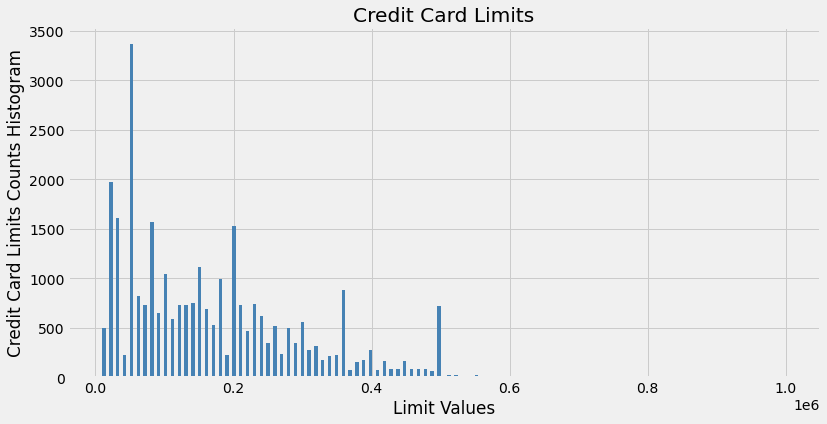

In [14]:
fig, ax = plt.subplots(figsize = (12,6))

ax.hist(df['LIMIT_BAL'], bins=200, color='steelblue');
ax.set_title('Credit Card Limits')
ax.set_xlabel('Limit Values')
ax.set_ylabel('Credit Card Limits Counts Histogram')

Apparently, the majority of the credit card limits are around 50000. 

In [15]:
df['LIMIT_BAL'].value_counts().head()

50000.0     3365
20000.0     1976
30000.0     1610
80000.0     1567
200000.0    1528
Name: LIMIT_BAL, dtype: int64

Let's now see the average credit limits, as well as their distribution according to their default status.

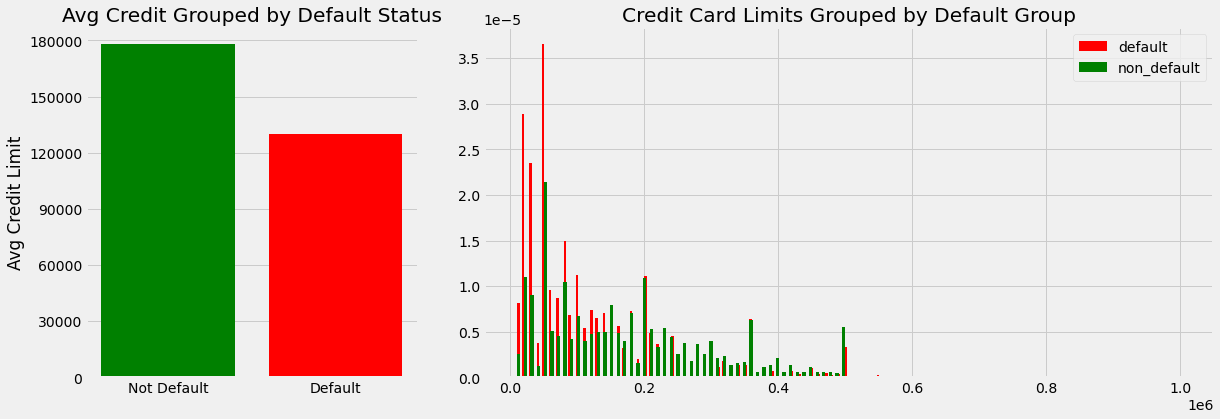

In [19]:
df_BAL = get_average_values('LIMIT_BAL')

fig = plt.figure(figsize = (18,6))
ax1 = plt.subplot2grid((1,3),(0,0))
ax2 = plt.subplot2grid((1,3),(0,1), colspan=2)

ax1.bar('default_payment','avg_values', data=df_BAL
       , color=('green','red'))
ax1.grid(axis='x')
ax1.set_xticks([0,1])
ax1.set_xticklabels(['Not Default','Default'], ha='center')
ax1.set_yticks(np.arange(0,180001,30000))
ax1.set_ylabel('Avg Credit Limit')
ax1.set_title('Avg Credit Grouped by Default Status')

default_df = df.loc[df['default_payment']==1]['LIMIT_BAL']
non_default_df = df.loc[df['default_payment']==0]['LIMIT_BAL']
ax2.hist(default_df, bins=200, color='red', density=True, label='default');
ax2.hist(non_default_df, bins=200, color='green', density=True, label='non_default');
ax2.set_title('Credit Card Limits Grouped by Default Group')
ax2.legend()

We can see that those who do not default on their credit card payment have a higher average credit card than those who do by about 5K. Also, the majority of those who default have credit limit values of about or less than 50k.


### Age

Let's repeat the same process for the distribution of the age of customers and their default status according to their age.

The following boxplot displays the distribution of age for the two "default" categories. Interestingly, the interquartile ranges for both "default" and "not default" categories is the same. For the "Default" case, it appears that there is a slightly higher concentration of customers below the age of 35. Apart from that the two boxplots are oddly similar; contrary to our expectation that those who don't default would be considerably older than those who do.

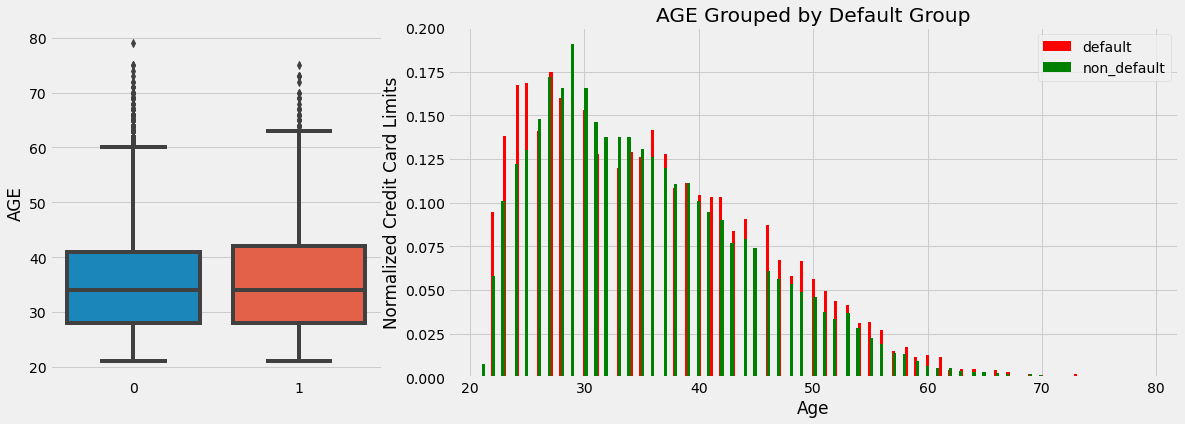

In [20]:
fig = plt.figure(figsize = (18,6))
ax1 = plt.subplot2grid((1,3),(0,0))
ax2 = plt.subplot2grid((1,3),(0,1), colspan=2)

sns.boxplot(y="AGE", x="default_payment", data=df, ax = ax1)
ax1.set_xlabel('')
ax1.set_xticks([0,1],['Not Default','Default'])

default_df = df.loc[df['default_payment']==1]['AGE']
non_default_df = df.loc[df['default_payment']==0]['AGE']
ax2.hist(default_df, bins=200, color='red', density=True, label='default');
ax2.hist(non_default_df, bins=200, color='green', density=True, label='non_default');
ax2.set_title('AGE Grouped by Default Group')
ax2.set_xlabel('Age')
ax2.set_ylabel('Normalized Credit Card Limits')
ax2.legend()

For the distribution of credit card limits for the two classes given the age of the customers, we can see that, in general, the majority of customers are under 35. Also, the main group of those who default on their next payment are between 25-30 years old.

### Feature Correlations

Finally, we need to consider the correlation between various features. Normally, we would want to use the most powerful features and get rid of the redundant ones. This also reduces multicollinearity in the feature space.

PAY_1 to PAY_6 are histories of past monsthly payments, from April to September, 2005 (in reverse order):
- -1 = pay duly
- 1 = payment delay for one month
- 2 = payment delay for two months
- etc

BILL_AMT1 to BILL_AMT6 are amount of bill statements from April to September, 2005, in reverse order.

Finally, PAY_AMT1 to PAY_AMT6 are amounts of previous payments from April to September, 2005, in reverse order.

The following heatmap shows the correlation between all the features in the dataset. Of notable correlations are "BILL_AMT" features with one another, then "PAY" features with eachother, respectively. It means that, in general, whether bill payments will be done on time or will have delays are somewhat correlated, but the bill statements are very correlated with eachother. This can be an issue when using models such as Logistic Linear Regression, but not so much for Decision Tree or Random Forest classifiers.

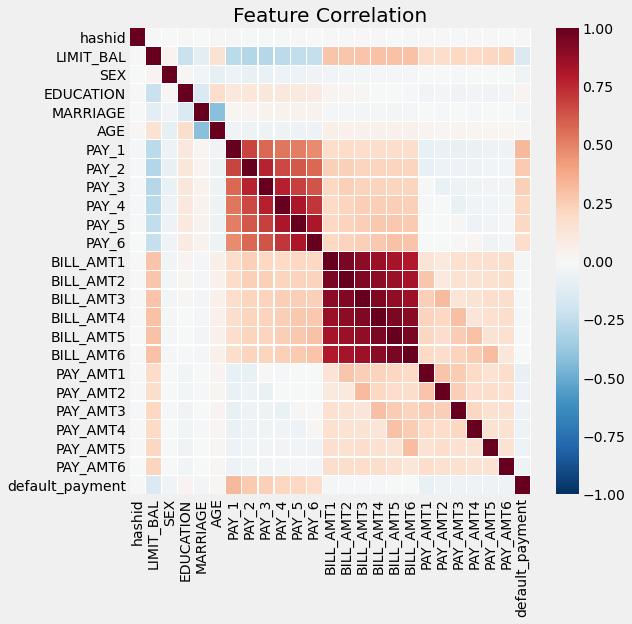

In [66]:
plt.figure(figsize = (8,8))

corr = df.corr()
sns.heatmap(corr,xticklabels=corr.columns,
            yticklabels=corr.columns,cmap="RdBu_r",linewidths=.1,vmin=-1, vmax=1)
plt.title('Feature Correlation')
plt.show()

<a id='build-model'></a>

# Building the model

When dealing with large datasets, we would want to build data piplelines and build the model on distibuted systems, like Google ML. 

Let's start by preprocessing the data.

<a id='preprocess'></a>

### Preprocessing using Dataflow

We'll be using Apache Beam to preprocess the data. Let's first install Apache Beam, and check that the correct [version](#version) has been installed:

In [5]:
%%bash
pip install apache-beam[gcp]==2.13.0 --user

<a id='version'></a>

In [193]:
import apache_beam as beam
print(beam.__version__)

2.13.0


First, we need to preprocess the data, create Train and Validation subsets of the data, and save them to the directory. I've defined the function `to_csv` that will go through each row of the dataset and write them to a csv file. This function will be used in the process of creating the piplelines using Apache beam in the subsequent function, `preprocess_data`.

The preprocessing involves of changing the labels of categorical columns, such as SEX, MARRIAGE, and EDUCATION:

In [50]:
def to_csv(row):
    import hashlib
    
    COLUMNS = ['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE','PAY_1','PAY_2','PAY_3',\
               'PAY_4','PAY_5','PAY_6','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4',\
               'BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4',\
               'PAY_AMT5','PAY_AMT6','default_payment']
        
    row['SEX'] = ['Male', 'Female'][row['SEX'] - 1]
    row['MARRIAGE'] = ['Unknown','Married','Single','Others'][row['MARRIAGE']]
    
    if row['EDUCATION']==0:
        row['EDUCATION'] = 5
    
    row['EDUCATION'] = ['Graduate','University','High-school','Others','Unknown1','Unknown2'][row['EDUCATION'] - 1]
    
    for pay in ['PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']:
        if row[pay] < 0:
            row[pay] = 0
    
    data = ','.join([str(row[k]) if k in row else 'None' for k in COLUMNS])
    
    ### hash the columns to create a key for each row
    key = hashlib.sha224(data.encode('utf-8')).hexdigest()  
    yield str('{},{}'.format(data, key))


Launching Dataflow job preprocess-credit-features-191112-025746 ... hang on


In [111]:
def preprocess_data(test_mode):
    import shutil, os, subprocess
    job_name = 'preprocess-credit-features' + '-' + datetime.datetime.now().strftime('%y%m%d-%H%M%S')

    if test_mode:
        print('Launching local job:')
        OUTPUT_DIR = './preproc'
        ### delete output directory if it exists
        shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
        ### create the directory
        os.makedirs(OUTPUT_DIR)
    else:
        print('Launching Dataflow job {}:'.format(job_name))
        OUTPUT_DIR = 'gs://{0}/credit_card/preproc/'.format(BUCKET)
        try:
            subprocess.check_call('gsutil -m rm -r {}'.format(OUTPUT_DIR).split())
        except:
            pass
    
    ### Let's define our own Apache Beam Options:
    options = {
      'staging_location': os.path.join(OUTPUT_DIR, 'tmp', 'staging'),
      'temp_location': os.path.join(OUTPUT_DIR, 'tmp'),
      'job_name': job_name,
      'project': PROJECT,
      'region': REGION,
      'max_num_workers': 6
       }
    opts = beam.pipeline.PipelineOptions(flags = [], **options)
    
    if test_mode:
        ### local mode
        RUNNER = 'DirectRunner'
    else:
        RUNNER = 'DataflowRunner'
        
    p = beam.Pipeline(RUNNER, options = opts)
    
    ### Let's create the Train and Validate Datasets:
    query = """
        SELECT 
            ABS(FARM_FINGERPRINT(CAST(ID AS STRING))) AS hashid,
            LIMIT_BAL,
            SEX,
            EDUCATION,
            MARRIAGE,
            AGE,
            PAY_0 AS PAY_1,
            PAY_2,
            PAY_3,
            PAY_4,
            PAY_5,
            PAY_6,
            CAST(BILL_AMT1 AS FLOAT64) AS BILL_AMT1,
            CAST(BILL_AMT2 AS FLOAT64) AS BILL_AMT2,
            CAST(BILL_AMT3 AS FLOAT64) AS BILL_AMT3,
            CAST(BILL_AMT4 AS FLOAT64) AS BILL_AMT4,
            CAST(BILL_AMT5 AS FLOAT64) AS BILL_AMT5,
            CAST(BILL_AMT6 AS FLOAT64) AS BILL_AMT6,
            CAST(PAY_AMT1 AS FLOAT64) AS PAY_AMT1,
            CAST(PAY_AMT2 AS FLOAT64) AS PAY_AMT2,
            CAST(PAY_AMT3 AS FLOAT64) AS PAY_AMT3,
            CAST(PAY_AMT4 AS FLOAT64) AS PAY_AMT4,
            CAST(PAY_AMT5 AS FLOAT64) AS PAY_AMT5,
            CAST(PAY_AMT6 AS FLOAT64) AS PAY_AMT6,
            CAST(default_payment_next_month AS INT64) AS default_payment
        FROM
          `subtle-digit-257500.credit_card.credit_card_1`
        """

    if test_mode:
        query = query + ' LIMIT 100' 

    for step in ['train', 'eval']:
        if step == 'train':
            selquery = 'SELECT * FROM ({}) WHERE MOD(ABS(hashid),4) < 3'.format(query)
        else:
            selquery = 'SELECT * FROM ({}) WHERE MOD(ABS(hashid),4) = 3'.format(query)

        (p 
         | '{}_read'.format(step) >> beam.io.Read(beam.io.BigQuerySource(query = selquery, use_standard_sql = True))
         | '{}_csv'.format(step) >> beam.FlatMap(to_csv)
         | '{}_out'.format(step) >> beam.io.Write(beam.io.WriteToText(os.path.join(OUTPUT_DIR, '{}.csv'.format(step))))
        )

    job = p.run()
    
    
    if test_mode:
        job.wait_until_finish()
        print("Done!")
    
preprocess_data(test_mode = False)

Launching Dataflow job preprocess-credit-features-191124-045735 ... hang on


Let's make sure the files are created on Google Cloud Platform:

In [51]:
%%bash
gsutil ls gs://${BUCKET}/credit_card/preproc/*-00000*

gs://credit_card_default/credit_card/preproc/eval.csv-00000-of-00001
gs://credit_card_default/credit_card/preproc/train.csv-00000-of-00002


<a id='train'></a>

## Training on Cloud AI Platform

Now, we are ready to build and train the model on AI platform. For this stage of building the model, we need to  create a Python Package with two modules,`task.py` that parses the arguments of the model specified in `model.py`.

In [65]:
%%writefile credit_card/trainer/task.py

import argparse
import json
import os

from . import model

import tensorflow as tf

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--bucket',
        help = 'Path to data on Google Cloud Storage. Default://BUCKET/credit-card/preproc/',
        required = True
    )
    parser.add_argument(
        '--output_dir',
        help = 'Location to write checkpoints and export models on Google Cloud Storage',
        required = True
    )
    parser.add_argument(
        '--batch_size',
        help = 'Size of batches of to compute gradients over in each epoch.',
        type = int,
        default = 256
    )
    parser.add_argument(
        '--job-dir',
        help = 'This model ignores this field, but it is required by gcloud',
        default = 'junk'
    )
    parser.add_argument(
        '--nnsize',
        help = 'Hidden layer sizes for DNN feature columns',
        nargs = '+',
        type = int,
        default=[128, 32, 4]
    )
    parser.add_argument(
        '--nembeds',
        help = 'Embedding size of a cross of n key real-valued parameters',
        type = int,
        default = 3
    )
 
    parser.add_argument(
        '--train_examples',
        help = 'Number of examples (in thousands) to run the training job over. This determines the number of epochs.',
        type = int,
        default = 3000
    )    
    parser.add_argument(
        '--pattern',
        help = 'Specify a pattern that has to be in input files.',
        default = 'of'
    )
    parser.add_argument(
        '--eval_steps',
        help = 'Positive number of steps for which to evaluate model. Default is None, meaning evaluate until input_fn raises an end-of-input exception',
        type = int,       
        default = None
    )
        
    ### parse all arguments
    args = parser.parse_args()
    arguments = args.__dict__

    ### unused args 
    arguments.pop('job_dir', None)

    ### assigning the arguments to the model variables
    output_dir = arguments.pop('output_dir')
    model.BUCKET     = arguments.pop('bucket')
    model.BATCH_SIZE = arguments.pop('batch_size')
    model.TRAIN_STEPS = (arguments.pop('train_examples') * 1000) / model.BATCH_SIZE
    model.EVAL_STEPS = arguments.pop('eval_steps')    
    
    print ("Will train for {} steps using batch_size={}".format(model.TRAIN_STEPS, model.BATCH_SIZE))
    
    model.PATTERN = arguments.pop('pattern')
    model.NEMBEDS= arguments.pop('nembeds')
    model.NNSIZE = arguments.pop('nnsize')
    print ("Will use DNN size of {}".format(model.NNSIZE))

    ### In the case of hyperparameter tuning, adds trial_id to the output path:
    output_dir = os.path.join(output_dir,
        json.loads(os.environ.get('TF_CONFIG', '{}')).get('task', {}).get('trial', ''))

    # Run the training job
    model.train_eval(output_dir)

Overwriting credit_card/trainer/task.py


`Model.py` modules contains the handles reading the dataset and creating an iterator to feed it to the model with `make_one_shot_iterator` which is the easiest one. It then defines the feature columns, whether they are numeric or categorical columns. We'll then divide the feature columns into wide or deep feature space; the wide feature columns are sparse columns, whereas deep columns are those that have continous values. We can feature-cross the wide columns and embed them into a lower dimension. We also need to create a serving function that can serve the model with input data at prediction time. We can even add an evaluating metric. I chose to add ROC AUC. And then finally train and evaluate the model, using `DNNLinearCombinedClassifier` tensorflow estimator, since we have both wide and deep feature columns. Because we're using tensorflow.estmator, we don't need to worry about defining the neural network layers as part of the  computational graph or create and run sessions.

In [90]:
%%writefile credit_card/trainer/model.py

import shutil
import numpy as np
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.INFO)

BUCKET = None  # set from task.py
PATTERN = 'of' # gets all files

# Determine CSV, label, and key columns
CSV_COLUMNS = ['LIMIT_BAL','SEX','EDUCATION','MARRIAGE','AGE','PAY_1','PAY_2','PAY_3',\
               'PAY_4','PAY_5','PAY_6','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4',\
               'BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4',\
               'PAY_AMT5','PAY_AMT6','default_payment','key']
LABEL_COLUMN = 'default_payment'
KEY_COLUMN = 'key'

# Set default values for each CSV column
DEFAULTS = [[0.0],['null'],['null'],['null'],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],
            [0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0.0],[0],['nokey']]

# Define some default hyperparameters
TRAIN_STEPS = 10000
EVAL_STEPS = None
BATCH_SIZE = 256
NEMBEDS = 3
NNSIZE = [64, 16, 4]

def read_dataset(prefix, mode, batch_size):
    def input_function():
        def decode_csv(value_column):
            ### Convert CSV records to tensors:
            columns = tf.decode_csv(value_column, record_defaults=DEFAULTS)
            features = dict(zip(CSV_COLUMNS, columns))
            label = features.pop(LABEL_COLUMN)
            return features, label
        
        file_path = 'gs://{}/credit_card/preproc/{}*{}*'.format(BUCKET, prefix, PATTERN)

        file_list = tf.gfile.Glob(file_path)
        
        ### Map csv files to tensor
        dataset = (tf.data.TextLineDataset(file_list).map(decode_csv))  
      
        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = None 
            ### Shuffle the datasets for each epoch of Gradient descent
            dataset = dataset.shuffle(buffer_size = 10 * batch_size)
        else:
            num_epochs = 1 
 
        dataset = dataset.repeat(num_epochs).batch(batch_size)
        return dataset.make_one_shot_iterator().get_next()
    return _input_fn

### Define Feature Columns
def get_wide_deep():
    LIMIT_BAL,SEX,MARRIAGE,EDUCATION,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,\
    BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,\
    PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6 = \
        [\
            tf.feature_column.numeric_column('LIMIT_BAL'),
            tf.feature_column.categorical_column_with_vocabulary_list('SEX', ['Male', 'Female']),
            tf.feature_column.categorical_column_with_vocabulary_list('MARRIAGE',['Unknown','Married','Single','Others']),
            tf.feature_column.categorical_column_with_vocabulary_list('EDUCATION',
                ['Graduate','University','High-school','Others','Unknown1','Unknown2']),
            tf.feature_column.numeric_column('AGE'),
            tf.feature_column.numeric_column('PAY_1'),
            tf.feature_column.numeric_column('PAY_2'),
            tf.feature_column.numeric_column('PAY_3'),
            tf.feature_column.numeric_column('PAY_4'),
            tf.feature_column.numeric_column('PAY_5'),
            tf.feature_column.numeric_column('PAY_6'),
            tf.feature_column.numeric_column('BILL_AMT1'),
            tf.feature_column.numeric_column('BILL_AMT2'),
            tf.feature_column.numeric_column('BILL_AMT3'),
            tf.feature_column.numeric_column('BILL_AMT4'),
            tf.feature_column.numeric_column('BILL_AMT5'),
            tf.feature_column.numeric_column('BILL_AMT6'),
            tf.feature_column.numeric_column('PAY_AMT1'),
            tf.feature_column.numeric_column('PAY_AMT2'),
            tf.feature_column.numeric_column('PAY_AMT3'),
            tf.feature_column.numeric_column('PAY_AMT4'),
            tf.feature_column.numeric_column('PAY_AMT5'),
            tf.feature_column.numeric_column('PAY_AMT6'),
        ]

    ### Discretize some of the numeric feature columns:
    balance_buckets = tf.feature_column.bucketized_column(LIMIT_BAL, 
                        boundaries=np.arange(10000,1000000,1000).tolist())
    age_buckets = tf.feature_column.bucketized_column(AGE, 
                        boundaries=np.arange(21,79,1).tolist())
    
    ### Wide (sparse) columns
    wide = [balance_buckets,age_buckets,SEX,MARRIAGE,EDUCATION]
    
    ### Feature cross wide columns and embed into a lower dimension:
    crossed = tf.feature_column.crossed_column(wide, hash_bucket_size=10000)
    embed = tf.feature_column.embedding_column(crossed, NEMBEDS)
    
    ### Deep (continuous) Columns
    deep = [LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,\
    BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,\
    PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,embed]
    
    return wide, deep


def serve_input():
    feature_placeholders = {
        'LIMIT_BAL':tf.placeholder(tf.float32, [None]),
        'SEX': tf.placeholder(tf.string, [None]),
        'MARRIAGE': tf.placeholder(tf.string, [None]),
        'EDUCATION': tf.placeholder(tf.string, [None]),
        'AGE': tf.placeholder(tf.float32, [None]),
        'PAY_1':tf.placeholder(tf.float32, [None]),
        'PAY_2':tf.placeholder(tf.float32, [None]),
        'PAY_3':tf.placeholder(tf.float32, [None]),
        'PAY_4':tf.placeholder(tf.float32, [None]),
        'PAY_5':tf.placeholder(tf.float32, [None]),
        'PAY_6':tf.placeholder(tf.float32, [None]),
        'BILL_AMT1':tf.placeholder(tf.float32, [None]),
        'BILL_AMT2':tf.placeholder(tf.float32, [None]),
        'BILL_AMT3':tf.placeholder(tf.float32, [None]),
        'BILL_AMT4':tf.placeholder(tf.float32, [None]),
        'BILL_AMT5':tf.placeholder(tf.float32, [None]),
        'BILL_AMT6':tf.placeholder(tf.float32, [None]),
        'PAY_AMT1':tf.placeholder(tf.float32, [None]),
        'PAY_AMT2':tf.placeholder(tf.float32, [None]),
        'PAY_AMT3':tf.placeholder(tf.float32, [None]),
        'PAY_AMT4':tf.placeholder(tf.float32, [None]),
        'PAY_AMT5':tf.placeholder(tf.float32, [None]),
        'PAY_AMT6':tf.placeholder(tf.float32, [None]),
        KEY_COLUMN: tf.placeholder_with_default(tf.constant(['nokey']), [None])
    }
    features = {
        key: tf.expand_dims(tensor, -1)
        for key, tensor in feature_placeholders.items()
    }
    return tf.estimator.export.ServingInputReceiver(features, feature_placeholders)

### Add evaluation metrics
def my_rmse(labels, predictions):
    pred_values = predictions['logistic']
    return {'auc': tf.metrics.auc(labels, pred_values, curve='ROC',summation_method='careful_interpolation')}


def train_eval(output_dir):
    tf.summary.FileWriterCache.clear() 
    wide, deep = get_wide_deep()
    EVAL_INTERVAL = 300 # in seconds

    ### Specify the estimator configuration: how often to write checkpoints and how many to keep 
    run_config = tf.estimator.RunConfig(save_checkpoints_secs = EVAL_INTERVAL,
                                        keep_checkpoint_max = 3)
    
    estimator = tf.estimator.DNNLinearCombinedClassifier(
        model_dir = output_dir,
        linear_feature_columns = wide,
        dnn_feature_columns = deep,
        dnn_hidden_units = NNSIZE,
        config = run_config)

    ### Add evaluating metric
    estimator = tf.contrib.estimator.add_metrics(estimator, my_rmse)
    
    ### Forward features to predictions dictionary:
    estimator = tf.contrib.estimator.forward_features(estimator, KEY_COLUMN)
    
    ### Configuration for the "train" part for the train_and_evaluate call:
    train_spec = tf.estimator.TrainSpec(
        input_fn = read_dataset('train', tf.estimator.ModeKeys.TRAIN, BATCH_SIZE),
        max_steps = TRAIN_STEPS)
    
    ### Export the serving graph and checkpoints for use in 
    exporter = tf.estimator.LatestExporter('exporter', serve_input, exports_to_keep=None) # disable garbage collection

    ### Configuration for the "eval" part for the train_and_evaluate call:
    eval_spec = tf.estimator.EvalSpec(
        input_fn = read_dataset('eval', tf.estimator.ModeKeys.EVAL, 2**15), 
        steps = EVAL_STEPS,
        start_delay_secs = 60, 
        throttle_secs = EVAL_INTERVAL, 
        exporters = exporter)

    ### train and evaluate:
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

Overwriting credit_card/trainer/model.py


We also need an init file in the package in order for the modules to work:

In [64]:
%%writefile credit_card/trainer/__init__.py

### __init__.py

Overwriting credit_card/trainer/__init__.py


After moving the code to a package, we need to make sure it works before deploying it on [Google AI Platform](#hyperparameters). 

In [92]:
%%bash
echo "bucket=${BUCKET}"
rm -rf credit_card_trained
export PYTHONPATH=${PYTHONPATH}:${PWD}/credit_card
echo ${PWD}
python -m trainer.task \
  --bucket=${BUCKET} \
  --output_dir=credit_card_trained \
  --job-dir=./tmp \
  --pattern="00000-of-" --train_examples=1 --eval_steps=1

bucket=credit_card_default
/home/jupyter
Will train for 3 steps using batch_size=256
Will use DNN size of [128, 32, 4]





INFO:tensorflow:Using config: {'_save_checkpoints_secs': 300, '_num_ps_replicas': 0, '_keep_checkpoint_max': 3, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f444c963b10>, '_model_dir': 'credit_card_trained/', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_device_fn': None, '_session_creation_timeout_secs': 7200, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_experimental_max_worker_delay_secs': None, '_evaluation_master': '', '_eval_distribute': None, '_train_distribute': None, '_master': ''}
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more informat

Let's check if the model can make a prediction. We'll feed it a json file specifying the feature values of the 100th example:

In [97]:
%%writefile inputs.json
{"LIMIT_BAL": 330000.0, "SEX": "Male", "MARRIAGE": "Single","EDUCATION": "Graduate", "AGE": 25.0,"PAY_1": 0.0,"PAY_2": 0.0,"PAY_3": 0.0,"PAY_4": 0.0,"PAY_5": 2.0,"PAY_6": 0.0,"BILL_AMT1": 46140.0,"BILL_AMT2": 45781.0,"BILL_AMT3": 48139.0,"BILL_AMT4": 51137.0,"BILL_AMT5": 39450.0,"BILL_AMT6": 25358.0,"PAY_AMT1": 2504.0,"PAY_AMT2": 4007.0,"PAY_AMT3": 5056.0,"PAY_AMT4": 74.0,"PAY_AMT5": 1023.0,"PAY_AMT6": 2566.0}

Overwriting inputs.json


In [98]:
%%bash
MODEL_LOCATION=$(ls -d $(pwd)/credit_card_trained/export/exporter/* | tail -1)
echo $MODEL_LOCATION
gcloud ai-platform local predict --model-dir=$MODEL_LOCATION --json-instances=inputs.json

/home/jupyter/credit_card_trained/export/exporter/1573531325
ALL_CLASS_IDS  ALL_CLASSES   CLASS_IDS  CLASSES  KEY         LOGISTIC  LOGITS               PROBABILITIES
[0, 1]         [u'0', u'1']  [1]        [u'1']   [u'nokey']  [1.0]     [1351.939208984375]  [0.0, 1.0]


If the signature defined in the model is not serving_default then you must specify it via --signature-name flag, otherwise the command may fail.






2019-11-12 04:06:24.224853: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2019-11-12 04:06:24.234237: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2019-11-12 04:06:24.234591: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55bd2a81b2c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2019-11-12 04:06:24.234679: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2019-11-12 04:06:24.235116: I tensorflow/core/common_runtime/process_util.cc:115] Creating 

In [99]:
df.iloc[100]['default_payment']

0.0

Since the model was run over 1 training example as a test, it's not surprising that it has mis-classified the input.

<a id='hyperparameters'></a>

## Tuning Hyperparameters

It's very important to tune hyperparameters. We'll create a file with different options for batch size, number of embeddings, and number of hidden layers, and we'll run the model with this file. We can choose the best options that have the highest AUC values (the rmse metric that we have added to the model). I have added an early stopping option to avoid overfitting:

In [100]:
%%writefile hyperparam.yaml
trainingInput:
  scaleTier: STANDARD_1
  hyperparameters:
    hyperparameterMetricTag: rmse
    goal: MINIMIZE
    maxTrials: 20
    maxParallelTrials: 5
    enableTrialEarlyStopping: True
    params:
    - parameterName: batch_size
      type: INTEGER
      minValue: 8
      maxValue: 512
      scaleType: UNIT_LOG_SCALE
    - parameterName: nembeds
      type: INTEGER
      minValue: 3
      maxValue: 30
      scaleType: UNIT_LINEAR_SCALE
    - parameterName: nnsize
      type: INTEGER
      minValue: 64
      maxValue: 512
      scaleType: UNIT_LOG_SCALE

Writing hyperparam.yaml


In [101]:
%%bash
OUTDIR=gs://${BUCKET}/credit_card/hyperparam
JOBNAME=credit_crad_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ai-platform jobs submit training $JOBNAME \
  --region=$REGION \
  --module-name=trainer.task \
  --package-path=$(pwd)/credit_card/trainer \
  --job-dir=$OUTDIR \
  --staging-bucket=gs://$BUCKET \
  --scale-tier=STANDARD_1 \
  --config=hyperparam.yaml \
  --runtime-version=1.14 \
  -- \
  --bucket=${BUCKET} \
  --output_dir=${OUTDIR} \
  --eval_steps=10 

gs://credit_card_default/credit_card/hyperparam us-central1 credit_crad_191112_041251
jobId: credit_crad_191112_041251
state: QUEUED


CommandException: 1 files/objects could not be removed.
Job [credit_crad_191112_041251] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe credit_crad_191112_041251

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs credit_crad_191112_041251


Let's output the results of the hyperparameter tuning to see which combination of hyperparameters provided the higherst AUC values:

In [103]:
%%bash
gcloud ai-platform jobs describe credit_crad_191112_041251

createTime: '2019-11-12T04:12:54Z'
endTime: '2019-11-12T04:50:12Z'
etag: T2N_YAl_cF0=
jobId: credit_crad_191112_041251
startTime: '2019-11-12T04:12:58Z'
state: SUCCEEDED
trainingInput:
  args:
  - --bucket=credit_card_default
  - --output_dir=gs://credit_card_default/credit_card/hyperparam
  - --eval_steps=10
  hyperparameters:
    enableTrialEarlyStopping: true
    goal: MINIMIZE
    hyperparameterMetricTag: rmse
    maxParallelTrials: 5
    maxTrials: 20
    params:
    - maxValue: 512.0
      minValue: 8.0
      parameterName: batch_size
      scaleType: UNIT_LOG_SCALE
      type: INTEGER
    - maxValue: 30.0
      minValue: 3.0
      parameterName: nembeds
      scaleType: UNIT_LINEAR_SCALE
      type: INTEGER
    - maxValue: 512.0
      minValue: 64.0
      parameterName: nnsize
      scaleType: UNIT_LOG_SCALE
      type: INTEGER
  jobDir: gs://credit_card_default/credit_card/hyperparam
  packageUris:
  - gs://credit_card_default/credit_crad_191112_041251/b94dda8a21f38be7ab085b5a8


View job in the Cloud Console at:
https://console.cloud.google.com/mlengine/jobs/credit_crad_191112_041251?project=subtle-digit-257500

View logs at:
https://console.cloud.google.com/logs?resource=ml.googleapis.com%2Fjob_id%2Fcredit_crad_191112_041251&project=subtle-digit-257500


The best result is given for batch_size of 202, nembeds=8, and nnsize=378, with AUC=0.618212.

We'll repeat the training with the tuned parameters.

In [104]:
%%bash
OUTDIR=gs://${BUCKET}/credit_card/trained_model_tuned
JOBNAME=credit_card_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ai-platform jobs submit training $JOBNAME \
  --region=$REGION \
  --module-name=trainer.task \
  --package-path=$(pwd)/credit_card/trainer \
  --job-dir=$OUTDIR \
  --staging-bucket=gs://$BUCKET \
  --scale-tier=STANDARD_1 \
  --runtime-version=1.14 \
  -- \
  --bucket=${BUCKET} \
  --output_dir=${OUTDIR} \
  --batch_size=202 --nembeds=8 --nnsize=378

gs://credit_card_default/credit_card/trained_model_tuned us-central1 credit_card_191112_135128
jobId: credit_card_191112_135128
state: QUEUED


CommandException: 1 files/objects could not be removed.
Job [credit_card_191112_135128] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe credit_card_191112_135128

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs credit_card_191112_135128


In [106]:
%%bash
gcloud ai-platform jobs describe credit_card_191112_135128

createTime: '2019-11-12T13:51:32Z'
endTime: '2019-11-12T13:59:57Z'
etag: BeComPlsMWQ=
jobId: credit_card_191112_135128
startTime: '2019-11-12T13:57:56Z'
state: SUCCEEDED
trainingInput:
  args:
  - --bucket=credit_card_default
  - --output_dir=gs://credit_card_default/credit_card/trained_model_tuned
  - --batch_size=202
  - --nembeds=8
  - --nnsize=378
  jobDir: gs://credit_card_default/credit_card/trained_model_tuned
  packageUris:
  - gs://credit_card_default/credit_card_191112_135128/41411cdab1a6dcce760f0c30664c6e2f08259ec47f0c0a7eecf79da89636fe00/trainer-0.0.0.tar.gz
  pythonModule: trainer.task
  region: us-central1
  runtimeVersion: '1.14'
  scaleTier: STANDARD_1
trainingOutput:
  consumedMLUnits: 0.68



View job in the Cloud Console at:
https://console.cloud.google.com/mlengine/jobs/credit_card_191112_135128?project=subtle-digit-257500

View logs at:
https://console.cloud.google.com/logs?resource=ml.googleapis.com%2Fjob_id%2Fcredit_card_191112_135128&project=subtle-digit-257500


<a id='deploy'></a>

## Deploying and Predicting with the Model

It's now time to use the model that we built to make predictions.

In [107]:
%%bash
gsutil ls gs://${BUCKET}/credit_card/trained_model_tuned/export/exporter/

gs://credit_card_default/credit_card/trained_model_tuned/export/exporter/
gs://credit_card_default/credit_card/trained_model_tuned/export/exporter/1573567167/


After locating the exporter files, we can go ahead and create the model and its version on AI platform.

In [109]:
%%bash
MODEL_NAME="credit_card"
MODEL_VERSION="ml_on_gcp"
MODEL_LOCATION=$(gsutil ls gs://${BUCKET}/credit_card/trained_model_tuned/export/exporter/ | tail -1)
echo "Deleting and deploying $MODEL_NAME $MODEL_VERSION from $MODEL_LOCATION ... this will take a few minutes"
#gcloud ai-platform versions delete ${MODEL_VERSION} --model ${MODEL_NAME}
#gcloud ai-platform models delete ${MODEL_NAME}
#gcloud ai-platform models create ${MODEL_NAME} --regions $REGION
gcloud ai-platform versions create ${MODEL_VERSION} --model ${MODEL_NAME} --origin ${MODEL_LOCATION} --runtime-version 1.14

Deleting and deploying credit_card ml_on_gcp from gs://credit_card_default/credit_card/trained_model_tuned/export/exporter/1573567167/ ... this will take a few minutes


Creating version (this might take a few minutes)......
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

<a id='predict'></a>

## Online prediction

Let's create a json file with the input values for the feature columns we'd like to make the predictions based on, and use google api to feed it to our model online:

In [110]:
from oauth2client.client import GoogleCredentials
import requests
import json

MODEL_NAME = 'credit_card'
MODEL_VERSION = 'ml_on_gcp'

token = GoogleCredentials.get_application_default().get_access_token().access_token
api = 'https://ml.googleapis.com/v1/projects/{}/models/{}/versions/{}:predict' \
         .format(PROJECT, MODEL_NAME, MODEL_VERSION)
headers = {'Authorization': 'Bearer ' + token }
data = {
  'instances': [
    { 'key': 'm1',
      'LIMIT_BAL': 330000.0, 
      'SEX': 'Male', 
      'MARRIAGE': 'Single',
      'EDUCATION': 'Graduate', 
      'AGE': 25.0,
      'PAY_1': 0.0,
      'PAY_2': 0.0,
      'PAY_3': 0.0,
      'PAY_4': 0.0,
      'PAY_5': 2.0,
      'PAY_6': 0.0,
      'BILL_AMT1': 46140.0,
      'BILL_AMT2': 45781.0,
      'BILL_AMT3': 48139.0,
      'BILL_AMT4': 51137.0,
      'BILL_AMT5': 39450.0,
      'BILL_AMT6': 25358.0,
      'PAY_AMT1': 2504.0,
      'PAY_AMT2': 4007.0,
      'PAY_AMT3': 5056.0,
      'PAY_AMT4': 74.0,
      'PAY_AMT5': 1023.0,
      'PAY_AMT6': 2566.0
    },
  ]
}
response = requests.post(api, json=data, headers=headers)
print(response.content)

b'{"predictions": [{"all_class_ids": [0, 1], "all_classes": ["0", "1"], "logistic": [0.0], "probabilities": [1.0, 0.0], "classes": ["0"], "key": ["m1"], "class_ids": [0], "logits": [-367.32861328125]}]}'


We can see that the model has correctly classified the category.